In [1]:
#pip install numpy scanpy seaborn matplotlib scipy anndata2ri rpy2 leidenalg

  Using cached numpy-2.0.2-cp39-cp39-macosx_10_9_x86_64.whl.metadata (60 kB)
  Using cached scanpy-1.10.3-py3-none-any.whl.metadata (9.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_10_12_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata (60 kB)
  Using cached rpy2-3.5.17.tar.gz (220 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ..done
  Preparing metadata (pyproject.toml) ...done
  Using cached leidenalg-0.10.2-cp38-abi3-macosx_10_9_x86_64.whl.metadata (10 kB)
  Using cached anndata-0.10.9-py3-none-any.whl.metadata (6.9 kB)
  Using cached get_annotations-0.1.2-py3-none-any.whl.metadata (3.3 kB)
  Using cached h5py-3.12.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata (2.5 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached legacy_api_wrap-1.4.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached natsort-8.

In [3]:
### import packages 
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

In [4]:
# define functions

def outlier_detection(adata, metric, devs):
    # adata should be an scRNAseq anndata object
    # metric is a string corresponding to the metric outliers are being detected on
    # divs is the number of median abosolute deviations (median(abs(Xi - median(X))) needed to be an outlier
    M = adata.obs[metric]
    outlier = (M < np.median(M) - devs * median_abs_deviation(M)) | (
            np.median(M) + devs * median_abs_deviation(M) < M
    )
    return outlier


In [5]:
### basic settings
sc.settings.verbosity = 0  # only show errors

sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)  # configure figure plotting


In [6]:

# load bone marrow dataset from the 2021 NeurIps conference
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata.var_names_make_unique()
adata
# should see anndata object with the shape n_obs x n_vars = 16934 x 36601 which corresponds to
# barcodes x transcripts (barcodes being unique cells and transcripts being the genes/gene things identified)


/opt/miniconda3/envs/test_jupyter_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/test_jupyter_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
### now that data is loaded, we will cull cells that are low quality, cells duos, and cell-free rna contaminated samples
# low quality cells will be selected based on three (mutual) criteria: low counts/barcode, low genes/barcode, MT gene fraction

# first mitochandrial, ribosomal, and heme genes.
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

# using our added Var entries, now calculate cell qc metrics. Note, this function will add several entries to the
# var and obs sections of our anndata object
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

/opt/miniconda3/envs/test_jupyter_env/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


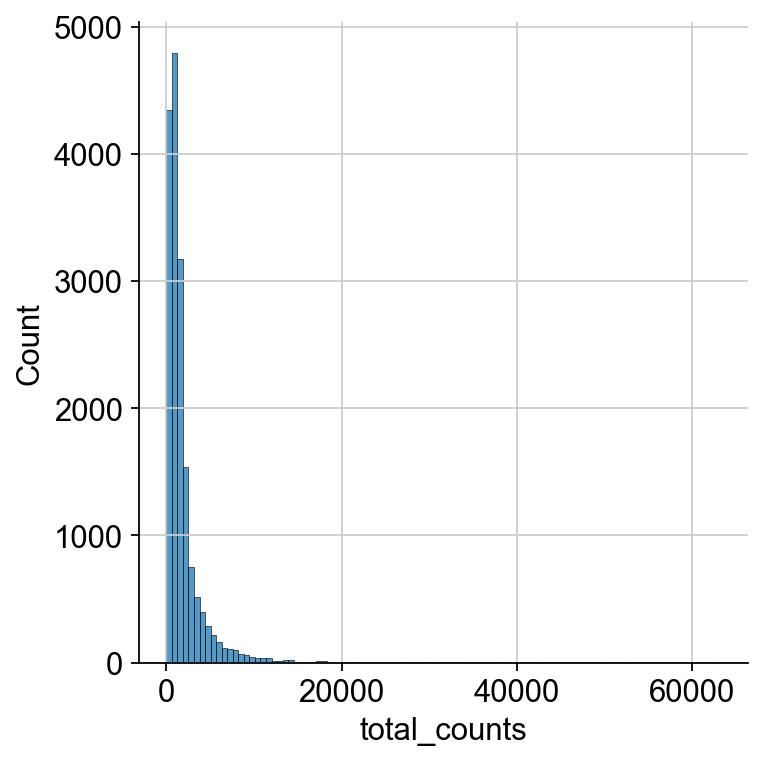

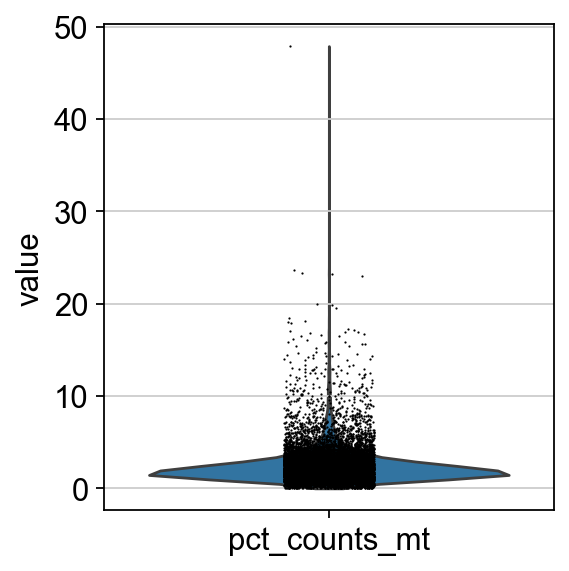

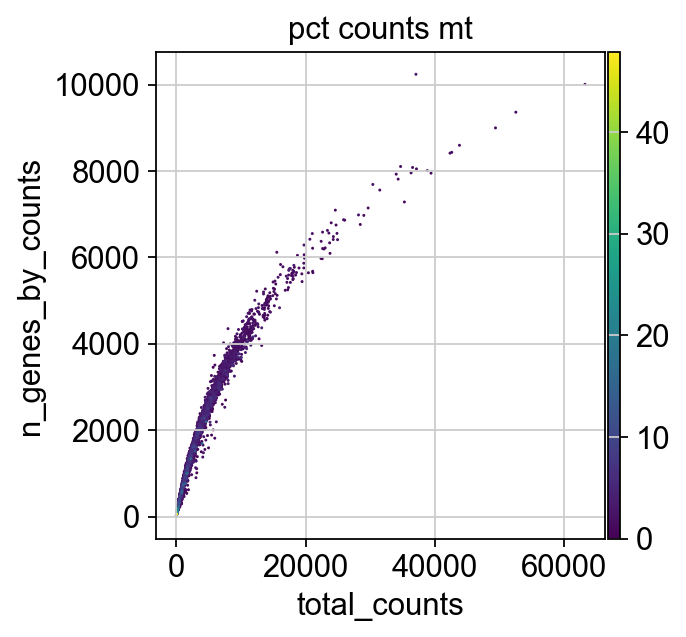

In [8]:

### what are the new fields? some important ones are below
# n_genes_by_counts in obs is the number of genes with counts per cell
# total_counts in obs is the total number of counts for a cell. aka library size (i.e. 5 genes with 10 counts gives 50)
# pct_counts_mt is the % of counts that are MT genes. a quick check shows that highest % MT in our data
max(adata.obs["pct_counts_mt"])

# plot time!
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [ ]:

# interpretation of plots: some cells have high pct count mito (violin plot)
# but the majority are under ~20% (scatter plot) so there is not something unsound
# with the dataset
# if interested you could do manual trhesholding using these plots (cut out high mito
# based on plots) or you could do an automated approach. This script will use the automated
# approach by removing cells that are divergent from the population median


In [9]:
### outlier detection
# apply the outlier detection function to log1p_total_counts, log1p_n_genes_by_counts, and
# pct_counts_in_top_20_genes metrics. the higher `devs` is, the more permissive the filtering
adata.obs["outlier"] = (
        outlier_detection(adata, "log1p_total_counts", 5)
        | outlier_detection(adata, "log1p_n_genes_by_counts", 5)
        | outlier_detection(adata, "pct_counts_in_top_20_genes", 5)
)
# check number of outliers
adata.obs.outlier.value_counts()

# filter based on just mt content, less permissive threshold since high mt gene counts are often
# associated with dead/dying cells
adata.obs["mt_outlier"] = outlier_detection(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
)
# apply filter based on these created columns
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Cells after filtering of low quality cells: 14814


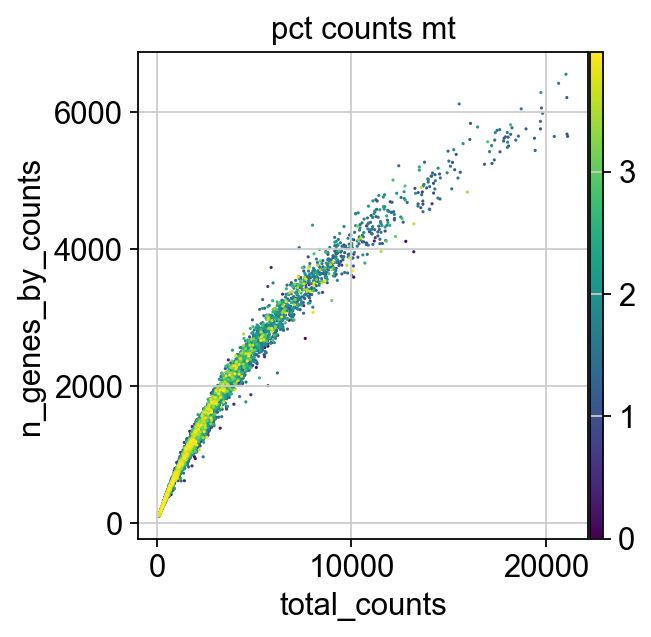

In [10]:
# visualize data following filtering, note the significantly lower pct of Mt genes
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [11]:
### Correction for ambient RNA using cellbender
# extracellular mRNA can contaminate droplets, representing reads that are from the cell containing solution rather
# than being from the cellin the droplet. To remove these contaminants (mRNA 'soup')
# note, this is done using a combination of r packages and python functions
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

/var/folders/01/vfjvpm8d56v305x78drk6tcc0000gp/T/ipykernel_54696/1151769434.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [13]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [16]:
# This cell is only necessary for first time install of r packages
# # import rpy2's package module
# import rpy2.robjects.packages as rpackages

# # import R's utility package
# utils = rpackages.importr('utils')

# # select a mirror for R packages
# utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface_lib.sexp.NULLType object at 0x1409b3c00> [RTYPES.NILSXP]

In [36]:
# utils.install_packages('SoupX')
# utils.install_packages('Seurat')
# utils.install_packages('BiocParallel')


The downloaded binary packages are in
	/var/folders/01/vfjvpm8d56v305x78drk6tcc0000gp/T//RtmpzvNDFJ/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x1409b3c00> [RTYPES.NILSXP]

In [ ]:
# %%R
# if (!requireNamespace("BiocManager", quietly=TRUE))
#     install.packages("BiocManager")
# BiocManager::install("scater")
# BiocManager::install("scDblFinder")

Update all/some/none? [a/s/n]: 

In [39]:
utils.install_packages('scater')

<rpy2.rinterface_lib.sexp.NULLType object at 0x1409b3c00> [RTYPES.NILSXP]

In [18]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [21]:
# prior to soupXing, we copy the adata object (to make a working copy), normalize the data (for clustering)
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
#using PCA we reduce the dimensionality of the data, calculate a knn graph for the data and leiden cluster the data

sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

In [22]:
# save soupX required inputs, SoupX requires a features x barcodes input, so transpose data
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [23]:
# load raw gene by cells matrix (raw_feature_...) in cellranger output
adata_raw = sc.read_10x_h5(
    filename="raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546217",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

  0%|          | 0.00/187M [00:00<?, ?B/s]

/opt/miniconda3/envs/test_jupyter_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/test_jupyter_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
del adata_raw

In [ ]:
# use magic to create an R cell, construct the SoupChannel, and run SoupX

In [29]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

560 genes passed tf-idf cut-off and 282 soup quantile filter.  Taking the top 100.
Using 484 independent estimates of rho.
Estimated global rho of 0.07
Expanding counts from 16 clusters to 14814 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


In [30]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

In [31]:
# for posterity's sake, check the genes filtered
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 20178


In [ ]:
### Now onto Doublet detection (removing droplets that had multiple cells. 
# Done by simulating doublets from data, seeing where those doublets cluster in PCA space, and dropping 
# their cluster. Done using scDblFinder R package

In [44]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [45]:
data_mat = adata.X.T

In [ ]:
# now can launch doublet detection using the created data_mat as an input to scDblFinder.
# this takes place within a SingleCellExperiment and adds its info as columns to the SCE


In [46]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~11852 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 3936 cells excluded from training.
iter=1, 4062 cells excluded from training.
iter=2, 4024 cells excluded from training.
Threshold found:0.55
3095 (20.9%) doublets called
In addition: Warning message:
In .checkSCE(sce) :
  Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out


In [47]:
# add data from doublet detection to the adata obs
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    11719
doublet     3095
Name: count, dtype: int64

In [48]:
# note: we don't necessarily need to remove these doublets now and it may be best to
# inspect douplets during visualization. Save data and pick up in Normalization
adata.write("s4d8_quality_control.h5ad")